In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import folium

In [2]:
# Load the area shapefile and line shapefile
pt_area_gdf = gpd.read_file('../data/map/Public Transport Victoria/gis_osm_transport_a_free_1.shp')
pt_line_gdf = gpd.read_file('../data/map/Public Transport Victoria/gis_osm_transport_free_1.shp')
pt_gdf = pd.concat([pt_area_gdf, pt_line_gdf], ignore_index=True)

# Load Victoria suburbs shapefile for filtering
vic_suburbs_gdf = gpd.read_file('../data/map/Vic_Localities/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp')
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(epsg=4326)

# Filter public transport stops that fall within Victoria
filtered_pt_gdf = gpd.sjoin(pt_gdf.to_crs(epsg=4326), vic_suburbs_gdf, how='inner', predicate='intersects')


In [3]:
# Filter train stations and tram stops
train_stops_gdf = filtered_pt_gdf[filtered_pt_gdf['fclass'].isin(['railway_station', 'railway_halt'])]
tram_stops_gdf = filtered_pt_gdf[filtered_pt_gdf['fclass'] == 'tram_stop']

In [5]:
# Create a map for Train Stops
train_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)  # Centered on Melbourne

# Ensure the geometries are points, otherwise, use centroids
for idx, row in train_stops_gdf.iterrows():
    # Check if the geometry is a point or polygon and extract centroid if necessary
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    folium.Marker(
        location=[geom.y, geom.x],  # Get coordinates from the centroid
        popup=f"Train Stop: {row['name']}",  # Popup with the name of the stop
        icon=folium.Icon(color='blue', icon='train')
    ).add_to(train_map)

# Save the Train Stops map
train_map.save('../plots/train_stops_map.html')

In [6]:
# Create a map for Tram Stops
tram_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)  # Zoom in a little closer for trams

# Ensure the geometries are points, otherwise, use centroids
for idx, row in tram_stops_gdf.iterrows():
    # Check if the geometry is a point or polygon and extract centroid if necessary
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    folium.Marker(
        location=[geom.y, geom.x],  # Get coordinates from the centroid
        popup=f"Tram Stop: {row['name']}",  # Popup with the name of the stop
        icon=folium.Icon(color='green', icon='info-sign')  # Green for tram stops
    ).add_to(tram_map)

# Save the Tram Stops map
tram_map.save('../plots/tram_stops_map.html')

In [7]:
# Create a combined map for both Train and Tram Stops
combined_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)  # Centered on Melbourne

# Add train stops to the map as blue markers
for idx, row in train_stops_gdf.iterrows():
    # Ensure geometry is a point or get the centroid of the polygon
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    folium.Marker(
        location=[geom.y, geom.x],
        popup=f"Train Stop: {row['name']}",
        icon=folium.Icon(color='blue', icon='train')
    ).add_to(combined_map)

# Add tram stops to the map as green markers
for idx, row in tram_stops_gdf.iterrows():
    # Ensure geometry is a point or get the centroid of the polygon
    geom = row.geometry.centroid if row.geometry.geom_type != 'Point' else row.geometry
    folium.Marker(
        location=[geom.y, geom.x],
        popup=f"Tram Stop: {row['name']}",
        icon=folium.Icon(color='green', icon='info-sign')  # Green for tram stops
    ).add_to(combined_map)

# Save the combined map with both train and tram stops
combined_map.save('../plots/combined_train_tram_stops_map.html')


In [14]:
# Combine train and tram stops into one GeoDataFrame for processing
train_tram_stops_gdf = pd.concat([train_stops_gdf, tram_stops_gdf])

# Perform the spatial join to associate the filtered train/tram stops with suburbs
pt_with_suburbs_gdf = gpd.sjoin(
    train_tram_stops_gdf, 
    vic_suburbs_gdf[['LOCALITY', 'geometry']], 
    how='inner', 
    predicate='intersects', 
    lsuffix='pt', rsuffix='suburb'  # Add suffixes to avoid column name conflicts
)

# Group by suburb using the correct column name 'LOCALITY_suburb'
suburb_accessibility = pt_with_suburbs_gdf.groupby('LOCALITY_suburb').size().reset_index(name='num_stops')


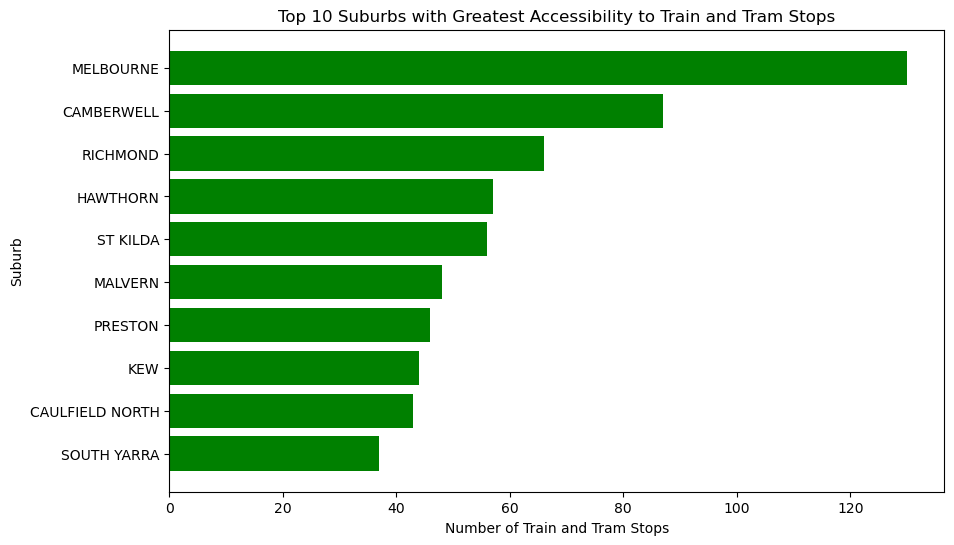

In [15]:
most_accessible_suburbs = suburb_accessibility.sort_values(by='num_stops', ascending=False).head(10)  # Top 10 most accessible
# Plot histogram for most accessible suburbs
plt.figure(figsize=(10, 6))
plt.barh(most_accessible_suburbs['LOCALITY_suburb'], most_accessible_suburbs['num_stops'], color='green')
plt.xlabel('Number of Train and Tram Stops')
plt.ylabel('Suburb')
plt.title('Top 10 Suburbs with Greatest Accessibility to Train and Tram Stops')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest at the top
plt.show()

## Break

In [3]:
# Ensure all GeoDataFrames have the same CRS (Coordinate Reference System)
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(area_gdf.crs)
line_gdf = line_gdf.to_crs(area_gdf.crs)

# Perform a spatial join or intersection to filter transport data within Victoria
area_gdf_vic = gpd.overlay(area_gdf, vic_suburbs_gdf, how='intersection')
line_gdf_vic = gpd.overlay(line_gdf, vic_suburbs_gdf, how='intersection')

# Drop non-serializable columns (datetime and potentially problematic object columns)
area_gdf_vic = area_gdf_vic.drop(columns=['PFI_CR', 'UFI_CR'], errors='ignore')
line_gdf_vic = line_gdf_vic.drop(columns=['PFI_CR', 'UFI_CR'], errors='ignore')



In [12]:
# Create a Folium map centered on Victoria
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=7)

# Add area data (polygons of public transport areas) to the map
folium.GeoJson(area_gdf_vic).add_to(m)

# Add line data (public transport routes) to the map
folium.GeoJson(line_gdf_vic, style_function=lambda x: {'color': 'red'}).add_to(m)

# Save the map as an HTML file and display
m.save("victoria_transport_map_filtered.html")
m

/var/folders/bz/yjywszk15kxc8d5vv73k9xcc0000gn/T/ipykernel_88938/2760486759.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


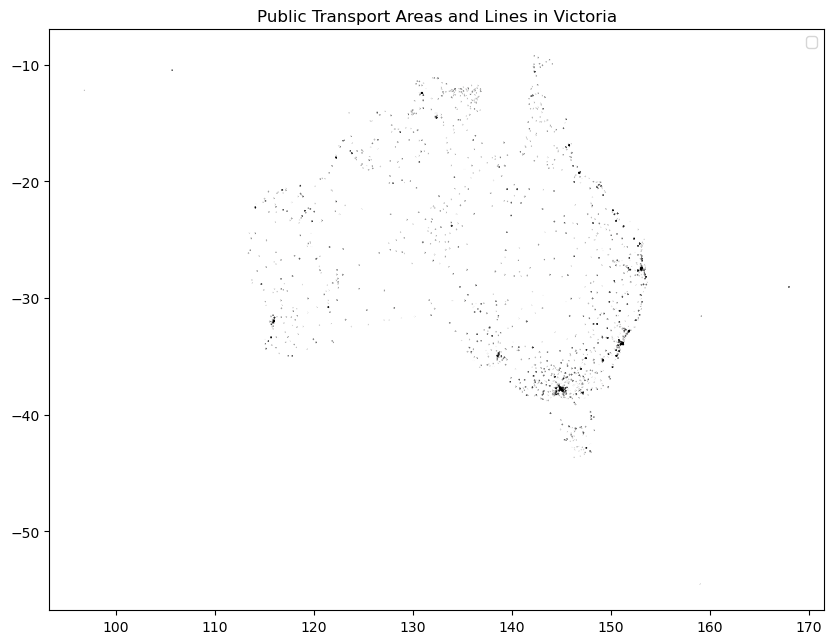

In [4]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the area shapefile (e.g., polygons of public transport regions)
area_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label="Areas")

# # Plot the line shapefile (e.g., public transport routes)
# line_gdf.plot(ax=ax, color='red', linewidth=1, label="Lines")

# Add title and legend
plt.title('Public Transport Areas and Lines in Victoria')
plt.legend()

# Show the plot
plt.show()